# INSTRM-1588

### We found pfs_utils returns different results across different versions.  This ticket double checks the results

In [18]:
import pathlib
from importlib import reload 
import matplotlib.pyplot as plt
import numpy as np
import os, fnmatch
import astropy.io.fits as pyfits
import pandas as pd

from procedures.moduleTest import visDianosticPlot
from ics.cobraCharmer import pfiDesign
from procedures.moduleTest import calculation
from opdb import opdb
from procedures.moduleTest import engineer as eng


reload(visDianosticPlot)
reload(calculation)
reload(eng)

<module 'procedures.moduleTest.engineer' from '/software/devel/pfs/ics_cobraCharmer/python/procedures/moduleTest/engineer.py'>

/software/devel/pfs/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:286: RuntimeWarning: divide by zero encountered in true_divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/software/devel/pfs/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:288: RuntimeWarning: divide by zero encountered in true_divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slowJoint2Rev)))
/software/devel/pfs/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:290: RuntimeWarning: divide by zero encountered in true_divide
  self.F1Nm[i] = angularStep / np.array(list(map(float, fastJoint1Rev)))


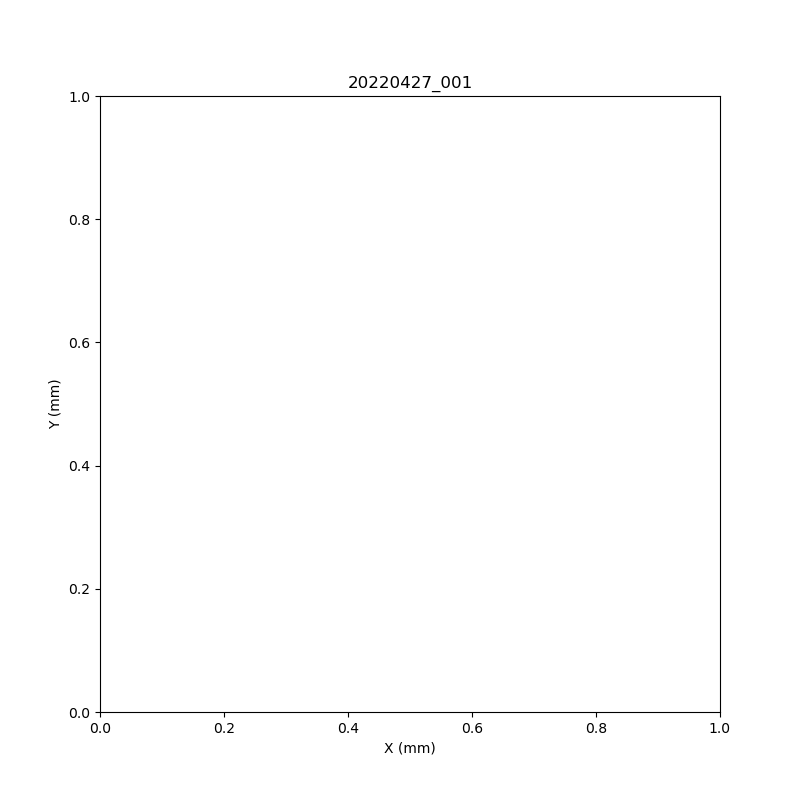

In [34]:
reload(visDianosticPlot)

xml= pathlib.Path('/software/devel/pfs/pfs_instdata/data/pfi/modules/ALL/ALL_final_20210920_mm.xml')


runDir = '20220427_001'

vis=visDianosticPlot.VisDianosticPlot(runDir=runDir,xml=xml,arm='phi', datatype='MM')

%matplotlib widget
vis.visCreateNewPlot(f'{runDir}', 'X (mm)', 'Y (mm)')

vis.visPlotFiberSpots()
#vis.visVisitAllSpots(psfVisitID = 72755, subVisit = 1, camera = 'rmod', dataRange=[0,50])
#vis.visPlotFiberSpots(cobraIdx=badRange, markCobra=True)




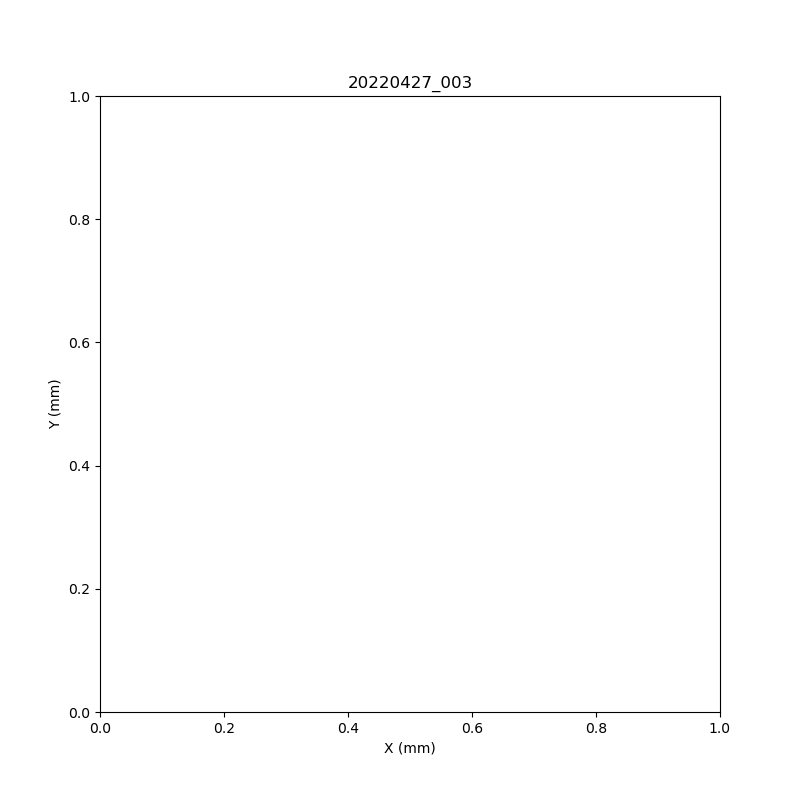

In [33]:
reload(visDianosticPlot)

xml= pathlib.Path('/software/devel/pfs/pfs_instdata/data/pfi/modules/ALL/ALL_final_20210920_mm.xml')


runDir = '20220427_003'

vis=visDianosticPlot.VisDianosticPlot(runDir=runDir,xml=xml,arm='phi', datatype='MM')

%matplotlib widget
vis.visCreateNewPlot(f'{runDir}', 'X (mm)', 'Y (mm)')

vis.visPlotFiberSpots()
#vis.visVisitAllSpots(psfVisitID = 72755, subVisit = 1, camera = 'rmod', dataRange=[0,50])
#vis.visPlotFiberSpots(cobraIdx=badRange, markCobra=True)





In [49]:
!setup -v pfs_utils 6.1.3

Setting up: pfs_utils                       Flavor: Linux64    Version: 6.1.3
Setting up: |pfs_instdata                   Flavor: Linux64    Version: git


In [50]:
import pfs.utils.coordinates.transform as transformUtils
from pfs.utils import butler 
from procedures.moduleTest import calculus



def getCentroidsFromDB(frameNum):
    fids = butler.Butler().get('fiducials')

    #frameNum=7275400
    db=opdb.OpDB(hostname='db-ics', port=5432,
                       dbname='opdb',
                       username='pfs')
    mcsData = db.bulkSelect('mcs_data','select * from mcs_data where '
                f'mcs_frame_id = {frameNum}').sort_values(by=['spot_id']).reset_index()
    teleInfo = db.bulkSelect('mcs_exposure','select altitude, insrot from mcs_exposure where '
                f'mcs_frame_id = {frameNum}')
    pt = transformUtils.fromCameraName('rmod',altitude=90, 
                            insrot=teleInfo['insrot'].values[0])

    outerRing = np.zeros(len(fids), dtype=bool)
    for i in [29, 30, 31, 61, 62, 64, 93, 94, 95, 96]:
            outerRing[fids.fiducialId == i] = True
    pt.updateTransform(mcsData, fids[outerRing], matchRadius=8.0, nMatchMin=0.1)

    for i in range(2):
        pt.updateTransform(mcsData, fids, matchRadius=4.2,nMatchMin=0.1)

    xx , yy = pt.mcsToPfi(mcsData['mcs_center_x_pix'],mcsData['mcs_center_y_pix'])
    centroids=np.rec.array([xx,yy],formats='float,float',names='x,y')
    centroids=centroids[~np.isnan(centroids['x'])]
    
    return centroids
    
def matchSpots(centroids, calibModel, tolerance=None, guess=None):

    if tolerance is not None:
        arm_radii = (calibModel.L1 + calibModel.L2)
        radii = (arm_radii * (1+tolerance))
    else:
        radii = None

    if guess is None:
        centers = vis.calibModel.centers
    elif len(guess) == len(vis.calibModel.centers):
        centers = guess
    elif len(guess) != len(idx):
        raise RuntimeError('len(guess) should be equal to the visible cobras or total cobras')
    else:
        centers = guess

    # Or fetch mcs-based match table here.
    #self.logger.info('Running object matching!')
    positions, indexMap = calculus.matchPositions(centroids, guess=centers, dist=radii)

    return positions
   
def extractPositions(frameNum, calibModel, tolerance=None, guess=None):
    
    if guess is None:
        centers = calibModel.centers
    elif len(guess) == 2394:
        centers = guess
    
    centroids = getCentroidsFromDB(frameNum)
    pos = matchSpots(centroids, calibModel, tolerance=tolerance, guess=centers)
    print(f'Postion for cobra ID0 = {pos[0]} guess = {centers[0]}')
    return pos
    #pass

In [51]:
pos = getCentroidsFromDB(7294602)#'72946'

/software/devel/pfs/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:286: RuntimeWarning: divide by zero encountered in true_divide
  self.S1Nm[i] = angularStep / np.array(list(map(float, slowJoint1Rev)))
/software/devel/pfs/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:288: RuntimeWarning: divide by zero encountered in true_divide
  self.S2Nm[i] = angularStep / np.array(list(map(float, slowJoint2Rev)))
/software/devel/pfs/ics_cobraCharmer/python/ics/cobraCharmer/pfiDesign.py:290: RuntimeWarning: divide by zero encountered in true_divide
  self.F1Nm[i] = angularStep / np.array(list(map(float, fastJoint1Rev)))


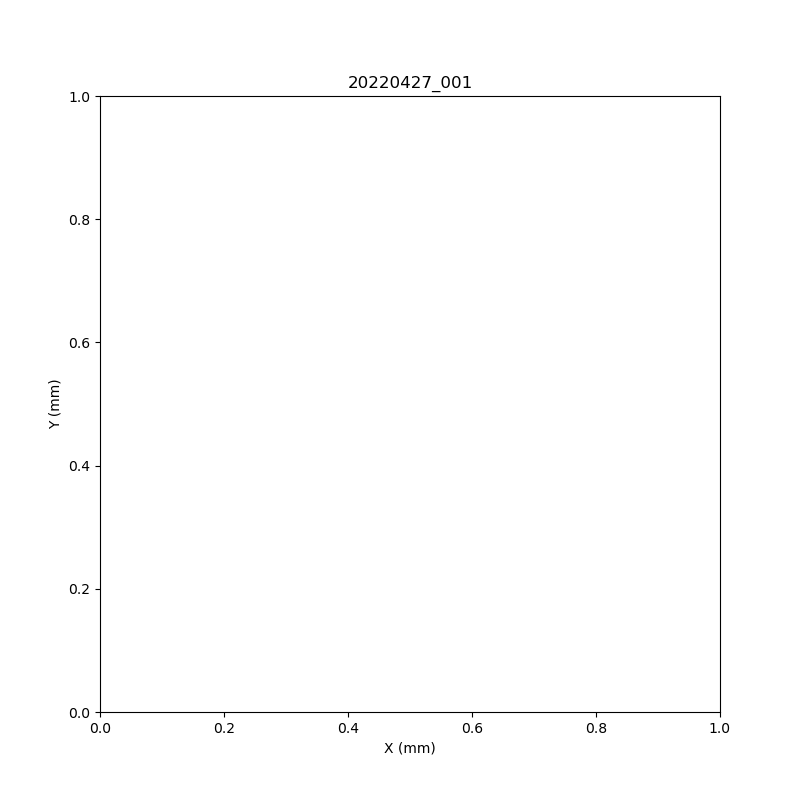

In [52]:
reload(visDianosticPlot)

xml= pathlib.Path('/software/devel/pfs/pfs_instdata/data/pfi/modules/ALL/ALL_final_20210920_mm.xml')


runDir = '20220427_001'

vis=visDianosticPlot.VisDianosticPlot(runDir=runDir,xml=xml,arm='phi', datatype='MM')

%matplotlib widget
vis.visCreateNewPlot(f'{runDir}', 'X (mm)', 'Y (mm)')

vis.visPlotFiberSpots(cobraIdx=[0,1,2])

ax=plt.gca()
ax.plot(pos['x'], pos['y'],'+')
